In [ ]:
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install pandas scikit-learn matplotlib numpy graphviz statsmodels

In [200]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor

import graphviz
from sklearn.tree import export_graphviz
from IPython.display import Image

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Predicting baseball games

Using the data compiled from `baseball_data_collection.ipynb`, start training and testing the model. I will primarily be using the `RandomForestRegressor` model from scikit-learn, but other models are also shown for comparison purposes.

In [2]:
version = 6
df = pd.read_csv(f'../data/baseball/training/game_data_v{version}.csv')

### Processing the data

Split the game data for training and testing, either by seasons (2017-22 for training, 2023 for testing) or randomly. Also, drop any columns that should not be included in the model, such as team names.

In [3]:
# create the appropriate training and testing data based on home/away, dropping columns as needed
def create_data(drop_cols=['away_score', 'home_score', 'away_team', 'home_team'], y_col='away_score', split_by='random'):
    y = df[y_col]
    x = df.drop(drop_cols, axis=1)

    if split_by == 'season':
        x_train, x_test = x.iloc[0:13047], x.iloc[13047:]
        y_train, y_test = y.iloc[0:13047], y.iloc[13047:]
    else:
        x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=True)
    
    return x_train, x_test, y_train, y_test

In [31]:
# add output columns (scores) to separate dataset
y = df['away_score']
# y = pd.DataFrame({'away_score': df['away_score'], 'home_score': df['home_score']})
# y = pd.DataFrame({'home_win': df['home_score'] > df['away_score']})['home_win']

# remove output columns and team names from input dataset
x = df.drop(['away_score', 'home_score', 'away_team', 'home_team', 'away_team_xfip', 'away_starter_xfip', 'home_team_xwoba_diff', 'home_lineup_xwoba'], axis=1)
# x = df.drop(['away_score', 'home_score', 'away_team', 'home_team'], axis=1)

### Model info and metrics

In [4]:
# figure out which features (columns) are being considered most by the model
def get_feature_importances(cols, model):
    feature_importances = {
        'feature': [],
        'weight': []
    }
    
    for i in range(len(cols)):
        feature_importances['feature'].append(cols[i])
        feature_importances['weight'].append(f'{round(model.feature_importances_[i] * 100, 2)}%')
    
    return pd.DataFrame(feature_importances)

In [5]:
# visualizing decision trees
# https://www.datacamp.com/tutorial/random-forests-classifier-python
def visualize_decision_trees(model, cols, n_trees=1, max_depth=2):
    for i in range(n_trees):
        tree = model.estimators_[i]
        dot_data = export_graphviz(tree,
                                   feature_names=cols,  
                                   filled=True,  
                                   max_depth=max_depth, 
                                   impurity=False, 
                                   proportion=True)
        graph = graphviz.Source(dot_data)
        display(graph)

In [6]:
# given a results dataframe, calculate the accuracy (in %) of the model in terms of predicting wins/losses
def wl_accuracy(results):
    num_correct = 0
    num_incorrect = 0
    
    for i in range(len(results)):
        game = results.iloc[i]
    
        pred_result = 1 if game['home_pred'] > game['away_pred'] else 0 # where 1 = home team wins
        actual_result = 1 if game['home_true'] > game['away_true'] else 0
        
        if pred_result == actual_result:
            num_correct += 1
        else:
            num_incorrect += 1

    return (num_correct / (num_correct + num_incorrect)) * 100

In [67]:
# calculate season records based on predictions
def predict_season_record(results):
    team_records = {}

    for i in range(len(results)):
        away_team = df['away_team'].iloc[13047 + i]
        home_team = df['home_team'].iloc[13047 + i]
        home_team_won = results['away_pred'].iloc[i] < results['home_pred'].iloc[i]
    
        if away_team not in team_records:
            team_records[away_team] = 0
    
        if home_team not in team_records:
            team_records[home_team] = 0
    
        team_records[away_team] += 1 if not home_team_won else 0
        team_records[home_team] += 1 if home_team_won else 0

    count = 0
    
    for team in team_records:
        count += 1
        print(f'{team}: {team_records[team]}-{162-team_records[team]}', end='\t')
        
        if count % 5 == 0:
            print()

## Random forest regressor

In [242]:
x_train_away, x_test_away, y_train_away, y_test_away = create_data(drop_cols=['away_score', 'home_score',
                                                                              'away_team', 'home_team'],
                                                                   y_col='away_score',
                                                                   split_by='season')
x_train_home, x_test_home, y_train_home, y_test_home = create_data(drop_cols=['away_score', 'home_score',
                                                                              'away_team', 'home_team'],
                                                                   y_col='home_score',
                                                                   split_by='season')

In [153]:
model_away = RandomForestRegressor(n_estimators=300, max_depth=3, max_features='sqrt', min_samples_leaf=5)
model_home = RandomForestRegressor(n_estimators=300, max_depth=3, max_features='sqrt', min_samples_leaf=5)

model_away.fit(x_train_away, y_train_away)
model_home.fit(x_train_home, y_train_home)

RandomForestRegressor(max_depth=3, max_features='sqrt', min_samples_leaf=5,
                      n_estimators=300)

In [154]:
pred_away = model_away.predict(x_test_away)
pred_home = model_home.predict(x_test_home)

results = pd.DataFrame({'away_pred': pred_away, 'home_pred': pred_home, 'away_true': y_test_away, 'home_true': y_test_home})
results.describe()

,away_pred,home_pred,away_true,home_true
count,2430.000000,2430.000000,2430.000000,2430.000000
mean,4.454809,4.578146,4.634979,4.596296
std,0.461506,0.391448,3.285711,3.150994
min,3.571991,3.726171,0.000000,0.000000
25%,4.102777,4.261093,2.000000,2.000000
50%,4.422949,4.536034,4.000000,4.000000
75%,4.754698,4.902742,6.000000,6.000000
max,5.957796,5.607305,25.000000,20.000000


In [155]:
print(f'Accuracy: {wl_accuracy(results)}%')

Accuracy: 57.69547325102881%


In [156]:
predict_season_record(results)

MIL: 126-36	CHC: 87-75	PIT: 21-141	CIN: 34-128	AZ: 34-128	
LAD: 147-15	NYM: 93-69	MIA: 65-97	COL: 9-153	SD: 118-44	
TOR: 140-22	STL: 59-103	ATL: 157-5	WSH: 18-144	BAL: 78-84	
BOS: 66-96	CWS: 28-134	HOU: 139-23	MIN: 125-37	KC: 30-132	
SF: 104-58	NYY: 102-60	LAA: 44-118	OAK: 2-160	CLE: 62-100	
SEA: 128-34	DET: 53-109	TB: 136-26	PHI: 133-29	TEX: 92-70	


### Increasing the variance

A random forest regressor with 300 decision trees and a maximum depth of 5 produces an accuracy of about 58%. This is great - most other models have an accuracy ranging from 55% to 60%. However, when I combine all the predicted outcomes and print the aggregate (i.e. the season win-loss record), the results appear to be extremely skewed. The Oakland Athletics (OAK), for instance, are predicted to lose almost every single game of the season. This can be partly explained by the low standard deviation of predicted runs scored, and one way to increase the variance is to decrease the number of decision trees (the `n_estimators` parameter) in the forest. I can also simply use the `DecisionTreeRegressor` model.

In [148]:
model_away = RandomForestRegressor(n_estimators=3, max_features='sqrt')
model_home = RandomForestRegressor(n_estimators=3, max_features='sqrt')

model_away.fit(x_train_away, y_train_away)
model_home.fit(x_train_home, y_train_home)

pred_away = model_away.predict(x_test_away)
pred_home = model_home.predict(x_test_home)

results = pd.DataFrame({'away_pred': pred_away, 'home_pred': pred_home, 'away_true': y_test_away, 'home_true': y_test_home})
results.describe()

print(f'Accuracy: {wl_accuracy(results)}%')
print('-' * 30)
predict_season_record(results)

Accuracy: 53.90946502057613%
------------------------------
MIL: 80-82	CHC: 96-66	PIT: 70-92	CIN: 62-100	AZ: 71-91	
LAD: 97-65	NYM: 92-70	MIA: 80-82	COL: 51-111	SD: 87-75	
TOR: 90-72	STL: 82-80	ATL: 109-53	WSH: 48-114	BAL: 90-72	
BOS: 87-75	CWS: 59-103	HOU: 110-52	MIN: 93-69	KC: 55-107	
SF: 88-74	NYY: 103-59	LAA: 61-101	OAK: 48-114	CLE: 74-88	
SEA: 95-67	DET: 75-87	TB: 88-74	PHI: 102-60	TEX: 87-75	


In [140]:
model_away = DecisionTreeRegressor(min_samples_leaf=10)
model_home = DecisionTreeRegressor(min_samples_leaf=10)

model_away.fit(x_train_away, y_train_away)
model_home.fit(x_train_home, y_train_home)

pred_away = model_away.predict(x_test_away)
pred_home = model_home.predict(x_test_home)

results = pd.DataFrame({'away_pred': pred_away, 'home_pred': pred_home, 'away_true': y_test_away, 'home_true': y_test_home})
results.describe()

print(f'Accuracy: {wl_accuracy(results)}%')
print('-' * 30)
predict_season_record(results)

Accuracy: 52.2633744855967%
------------------------------
MIL: 108-54	CHC: 75-87	PIT: 69-93	CIN: 64-98	AZ: 80-82	
LAD: 106-56	NYM: 87-75	MIA: 71-91	COL: 48-114	SD: 92-70	
TOR: 80-82	STL: 78-84	ATL: 116-46	WSH: 57-105	BAL: 82-80	
BOS: 91-71	CWS: 66-96	HOU: 111-51	MIN: 108-54	KC: 61-101	
SF: 90-72	NYY: 85-77	LAA: 75-87	OAK: 35-127	CLE: 75-87	
SEA: 90-72	DET: 66-96	TB: 87-75	PHI: 93-69	TEX: 84-78	


### Selecting features

By using fewer decision trees, the aggregate records came out to be more realistic - even if it did come at the cost of losing some accuracy.

There is another problem with this random forest model, though. The output below shows how much each column is weighted when making predictions for how many runs the home team will score. We can see that, for example, `home_starter_xfip` is weighted 11.3% - but does the home team's starting *pitcher* really have that much effect on the home team's *batting* results? I tried to fine-tune the model by removing unnecessary or irrelevant features.

In [82]:
get_feature_importances(x_test_home.columns, model_home)

,feature,weight
0,away_team_xwoba_diff,5.28%
1,away_lineup_xwoba,12.34%
2,away_team_xfip,5.71%
3,away_starter_xfip,12.39%
4,away_close_win_pct,6.2%
5,away_run_diff,7.36%
6,home_team_xwoba_diff,6.36%
7,home_lineup_xwoba,12.83%
8,home_team_xfip,6.53%
9,home_starter_xfip,11.3%


In [102]:
x_train_away, x_test_away, y_train_away, y_test_away = create_data(drop_cols=['away_score', 'home_score',
                                                                              'away_team', 'home_team',
                                                                              'away_team_xfip', 'away_starter_xfip',
                                                                              'home_team_xwoba_diff', 'home_lineup_xwoba'],
                                                                   y_col='away_score',
                                                                   split_by='season')
x_train_home, x_test_home, y_train_home, y_test_home = create_data(drop_cols=['away_score', 'home_score',
                                                                              'away_team', 'home_team',
                                                                              'home_team_xfip', 'home_starter_xfip',
                                                                              'away_team_xwoba_diff', 'away_lineup_xwoba'],
                                                                   y_col='home_score',
                                                                   split_by='season')

In [115]:
model_away = RandomForestRegressor(n_estimators=3, max_features='sqrt', min_samples_leaf=2)
model_home = RandomForestRegressor(n_estimators=3, max_features='sqrt', min_samples_leaf=2)

model_away.fit(x_train_away, y_train_away)
model_home.fit(x_train_home, y_train_home)

pred_away = model_away.predict(x_test_away)
pred_home = model_home.predict(x_test_home)

results = pd.DataFrame({'away_pred': pred_away, 'home_pred': pred_home, 'away_true': y_test_away, 'home_true': y_test_home})
results.describe()

print(f'Accuracy: {wl_accuracy(results)}%')
print('-' * 30)
predict_season_record(results)

Accuracy: 51.81069958847737%
------------------------------
MIL: 87-75	CHC: 80-82	PIT: 59-103	CIN: 57-105	AZ: 85-77	
LAD: 115-47	NYM: 75-87	MIA: 92-70	COL: 43-119	SD: 91-71	
TOR: 102-60	STL: 87-75	ATL: 119-43	WSH: 44-118	BAL: 76-86	
BOS: 92-70	CWS: 65-97	HOU: 85-77	MIN: 112-50	KC: 60-102	
SF: 80-82	NYY: 79-83	LAA: 63-99	OAK: 35-127	CLE: 79-83	
SEA: 106-56	DET: 58-104	TB: 96-66	PHI: 96-66	TEX: 112-50	


In [104]:
get_feature_importances(x_test_home.columns, model_home)

,feature,weight
0,away_team_xfip,11.23%
1,away_starter_xfip,19.29%
2,away_close_win_pct,9.17%
3,away_run_diff,9.9%
4,home_team_xwoba_diff,10.71%
5,home_lineup_xwoba,19.39%
6,home_close_win_pct,9.58%
7,home_run_diff,10.72%


### Testing for multicollinearity

https://www.datasklr.com/ols-least-squares-regression/multicollinearity

https://online.stat.psu.edu/stat462/node/180/

In [243]:
ols_model = sm.OLS(y_train_home, sm.add_constant(x_train_home)).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:             home_score   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     51.34
Date:                Thu, 18 Jul 2024   Prob (F-statistic):          3.71e-121
Time:                        15:05:20   Log-Likelihood:                -33345.
No. Observations:               13047   AIC:                         6.672e+04
Df Residuals:                   13034   BIC:                         6.681e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -5.5772 

In [246]:
x_temp = sm.add_constant(x_train_home)

vif = pd.DataFrame()
vif['feature'] = x_temp.columns
vif['variance_inflation_factor'] = [variance_inflation_factor(x_temp.values, i) for i in range(x_temp.values.shape[1])]
vif

,feature,variance_inflation_factor
0,const,865.888064
1,away_team_xfip,2.913451
2,away_starter_xfip,1.448382
3,away_close_win_pct,1.430056
4,away_run_diff,2.909574
5,home_lineup_xwoba,1.195721
6,home_close_win_pct,1.180742


In [245]:
x_train_away, x_test_away, y_train_away, y_test_away = create_data(drop_cols=['away_score', 'home_score',
                                                                              'away_team', 'home_team',
                                                                              'away_team_xfip', 'away_starter_xfip',
                                                                              'home_team_xwoba_diff', 'home_lineup_xwoba',
                                                                              'away_team_xwoba_diff', 'away_run_diff'],
                                                                   y_col='away_score',
                                                                   split_by='season')
x_train_home, x_test_home, y_train_home, y_test_home = create_data(drop_cols=['away_score', 'home_score',
                                                                              'away_team', 'home_team',
                                                                              'home_team_xfip', 'home_starter_xfip',
                                                                              'away_team_xwoba_diff', 'away_lineup_xwoba',
                                                                              'home_team_xwoba_diff', 'home_run_diff'],
                                                                   y_col='home_score',
                                                                   split_by='season')

In [234]:
model_away = RandomForestRegressor(n_estimators=3, max_features='sqrt', min_samples_leaf=2)
model_home = RandomForestRegressor(n_estimators=3, max_features='sqrt', min_samples_leaf=2)

model_away.fit(x_train_away, y_train_away)
model_home.fit(x_train_home, y_train_home)

pred_away = model_away.predict(x_test_away)
pred_home = model_home.predict(x_test_home)

results = pd.DataFrame({'away_pred': pred_away, 'home_pred': pred_home, 'away_true': y_test_away, 'home_true': y_test_home})
results.describe()

print(f'Accuracy: {wl_accuracy(results)}%')
print('-' * 30)
predict_season_record(results)

Accuracy: 55.144032921810705%
------------------------------
MIL: 83-79	CHC: 95-67	PIT: 64-98	CIN: 63-99	AZ: 60-102	
LAD: 108-54	NYM: 85-77	MIA: 73-89	COL: 62-100	SD: 91-71	
TOR: 111-51	STL: 81-81	ATL: 120-42	WSH: 59-103	BAL: 84-78	
BOS: 80-82	CWS: 63-99	HOU: 99-63	MIN: 87-75	KC: 55-107	
SF: 82-80	NYY: 78-84	LAA: 77-85	OAK: 39-123	CLE: 83-79	
SEA: 98-64	DET: 75-87	TB: 98-64	PHI: 106-56	TEX: 71-91	


In [239]:
get_feature_importances(x_test_home.columns, model_home)

,feature,weight
0,away_team_xfip,9.99%
1,away_starter_xfip,20.21%
2,away_close_win_pct,10.98%
3,away_run_diff,12.28%
4,home_lineup_xwoba,27.81%
5,home_close_win_pct,18.74%


### Comparing to linear regression

In [230]:
model_away = LinearRegression()
model_home = LinearRegression()

model_away.fit(x_train_away, y_train_away)
model_home.fit(x_train_home, y_train_home)

pred_away = model_away.predict(x_test_away)
pred_home = model_home.predict(x_test_home)

results = pd.DataFrame({'away_pred': pred_away, 'home_pred': pred_home, 'away_true': y_test_away, 'home_true': y_test_home})
results.describe()

print(f'W/L accuracy: {wl_accuracy(results)}%')
predict_season_record(results)

W/L accuracy: 59.135802469135804%
MIL: 102-60	CHC: 98-64	PIT: 24-138	CIN: 54-108	AZ: 41-121	
LAD: 147-15	NYM: 100-62	MIA: 64-98	COL: 7-155	SD: 120-42	
TOR: 127-35	STL: 75-87	ATL: 153-9	WSH: 11-151	BAL: 80-82	
BOS: 78-84	CWS: 27-135	HOU: 135-27	MIN: 124-38	KC: 34-128	
SF: 96-66	NYY: 100-62	LAA: 58-104	OAK: 1-161	CLE: 58-104	
SEA: 114-48	DET: 56-106	TB: 119-43	PHI: 123-39	TEX: 104-58	


### Comparing to random

Just out of curiousty :P

In [188]:
def generate_random_results():
    results = {'away_pred': [], 'home_pred': [], 'away_true': y_test_away, 'home_true': y_test_home}
    
    for i in range(len(y_test_away)):
        results['away_pred'].append(random.randint(0, 1))
        results['home_pred'].append(1 - results['away_pred'][i])
    
    return pd.DataFrame(results)

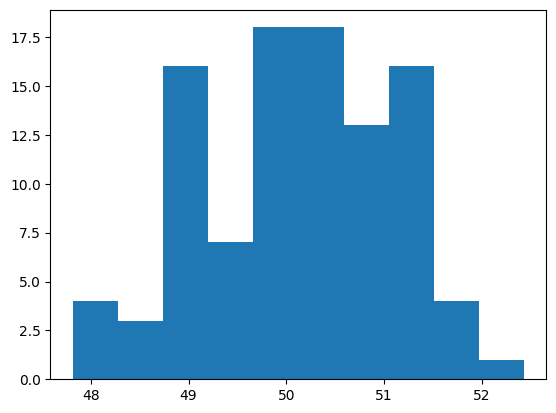

,0
count,100.000000
mean,50.101235
std,0.988406
min,47.818930
25%,49.403292
50%,50.164609
75%,50.915638
max,52.427984


In [189]:
acc = []

for i in range(100):
    results = generate_random_results()
    acc.append(wl_accuracy(results))

plt.hist(acc)
plt.show()

pd.DataFrame(acc).describe()

## Misc

Decision tree for predicting away score:


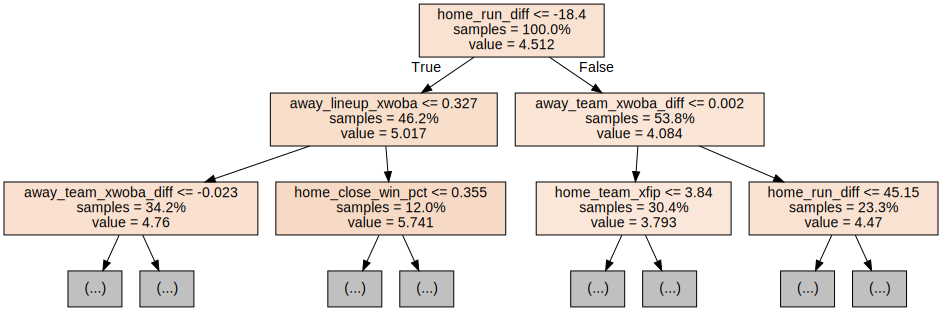


Decision tree for predicting home score:


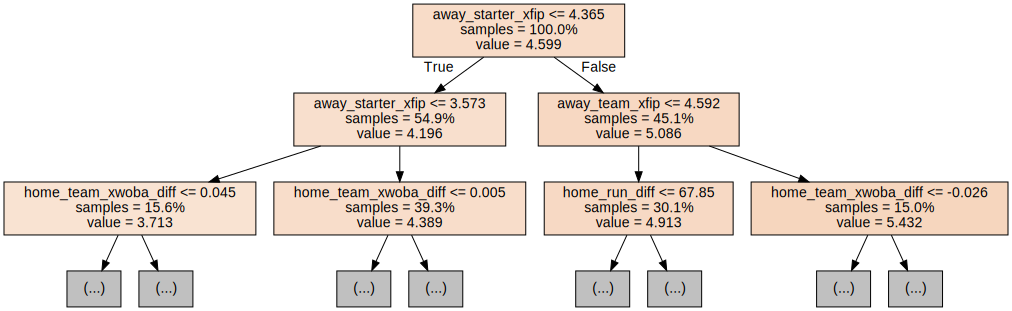

In [77]:
print('Decision tree for predicting away score:')
visualize_decision_trees(model_away, x_test_away.columns)

print()

print('Decision tree for predicting home score:')
visualize_decision_trees(model_home, x_test_home.columns)

In [24]:
model_cv = GridSearchCV(estimator=MultiOutputRegressor(RandomForestRegressor()),
                        param_grid={
                            'estimator__n_estimators': [],
                            'estimator__max_depth': [2, 4, 6, 8, 10],
                        },
                        # scoring={
                        #     'accuracy': make_scorer(wl_accuracy),
                        # },
                        # refit='accuracy',
                        cv=5)

Correlation coefficient (away team): r=0.21497074779894154
Correlation coefficient (home team): r=0.20828820312352855


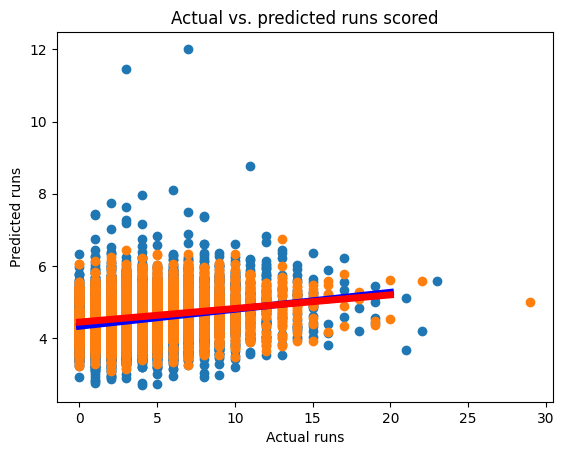

In [15]:
# drawing a scatterplot with regression line
# https://python-graph-gallery.com/scatterplot-with-regression-fit-in-matplotlib/

plt.scatter(y_test['away_score'], pred_df[0])
plt.scatter(y_test['home_score'], pred_df[1])


m_away, b_away = np.polyfit(y_test['away_score'], pred_df[0], deg=1)
x_away = np.linspace(0, 20, num=1000)

plt.plot(x_away, m_away * x_away + b_away, color='b', lw=5)

r_away = np.corrcoef(y_test['away_score'], pred_df[0])
print(f'Correlation coefficient (away team): r={r_away[0][1]}')


m_home, b_home = np.polyfit(y_test['home_score'], pred_df[1], deg=1)
x_home = np.linspace(0, 20, num=1000)

plt.plot(x_home, m_home * x_home + b_home, color='r', lw=5)

r_home = np.corrcoef(y_test['home_score'], pred_df[1])
print(f'Correlation coefficient (home team): r={r_home[0][1]}')


plt.xlabel('Actual runs')
plt.ylabel('Predicted runs')
plt.title('Actual vs. predicted runs scored')

plt.show()

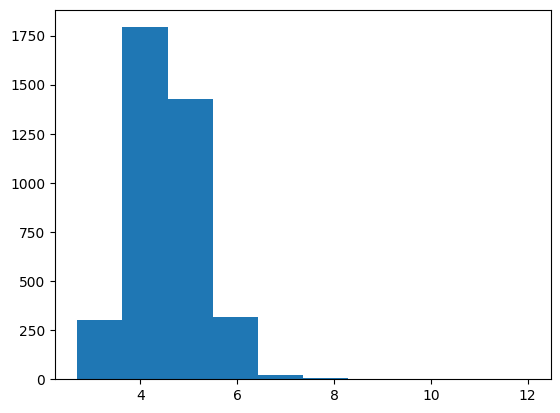

In [16]:
plt.hist(pred_df[0])
plt.show()

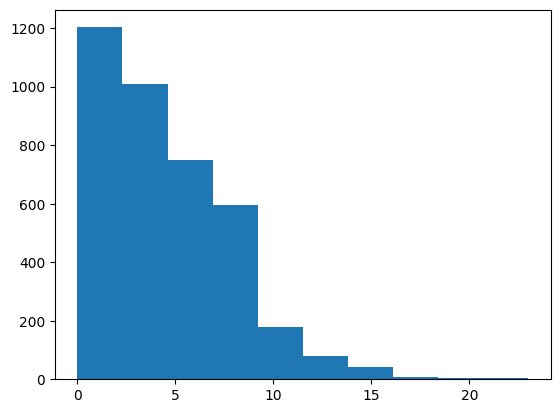

In [17]:
plt.hist(y_test['away_score'])
plt.show()

In [64]:
0.19371346717243468 ** 2

0.03752490736396593

In [78]:
# why is standard deviation so low? -> should it be that way?
# try a logistic regression for comparison

# experiment with monthly stats
# grid search cv


# experiment with past 2 season data - pretty much the same
# build a histogram of runs predicted
# figure out rookie average stats